In [2]:
from neuron import h, gui
from neuron.units import ms, mV
h.load_file('SK2017_mosinit.hoc')
#import hpca_session
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import style, rc
import numpy as np
import pickle
style.use("seaborn")
%matplotlib notebook

# Functions for convenient handling of simulations

In [24]:
def run_simulation(k_out=0.002, total_protein=0.03821, runtime=1200, color='black'):
    
    h.TotalHPCA_hpca = total_protein # mM
    h.k8HPCA_hpca = k_out # /ms

    v_soma = h.Vector().record(h.soma(0.5)._ref_v)
    ncs_m = h.Vector().record(h.dend11[10](0.5)._ref_HPCA_m_hpca[0])
    sahpc = h.Vector().record(h.dend11[10](0.5)._ref_ik_hpca)
    time = h.Vector().record(h._ref_t)
    h.finitialize()
    h.continuerun(runtime * ms)
    fig, axs = plt.subplots(3, sharex=True)
    fig.suptitle('Response to synaptic input')
    axs[0].plot(time/1000, v_soma)
    axs[0].set(ylabel='mV')
    axs[1].plot(time/1000, ncs_m*10**3)
    axs[1].set(ylabel='mM')
    axs[2].plot(time/1000, sahpc)
    axs[2].set(xlabel='time [s]', ylabel='uA')
    #plot_timecourse(time, v_soma, label='soma', ylabel='mV', color=color)
    #plot_timecourse(time, ncs_m*10**3, label='memb conc of NCS', ylabel='uM', color=color)
    #plot_timecourse(time, sahpc*10**3, label='sAHP current', ylabel='uA',color=color)

def plot_timecourse(time_array, dependent_var, newfigure=True, 
                    show=True, label=None, color='black', ylabel=None, constants=None):
    if newfigure:
        plt.figure()
    plt.plot(time_array, dependent_var, label=label, color=color, lw=.8)
    plt.xlabel('t (ms)')
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.legend()
    if show:
        plt.show()

def create_ncs_distribution(locations):
    for section in locations:
        current_section = h.dend11[section]
        # insert hpca mechanism to the section
        current_section.insert('hpca')
        # uninsert current that works with cad.mod
        current_section.uninsert('Ca_HVA')
        # insert current that works with hpca
        current_section.insert('cal')
        current_section.uninsert('cad')

def delete_all_ncs_mechanisms():
    for section in range(12, 82):
        current_section = h.dend11[section]
        current_section.uninsert('hpca')
        current_section.insert('Ca_HVA')
        current_section.uninsert('cal')
        current_section.insert("cad")


In [33]:
from random import randint, uniform, seed

class Synapse:

    num_synapses = 0
    gmax_AMPA = 0.001 
    gmax_NMDA = 0.7 * 0.001

    def __init__(self, loc, start):
        '''Create AMPA/NMDA synapse at given location ('loc' argument)
        '''
        self.loc = loc
        self.GluSyn = h.SimpleAMPA_NMDA(self.loc)
        self.stim = h.NetStim()
        self.stim.interval = 20 * ms
        self.stim.start = start * ms
        self.stim.number = 5
        
        # second synaptic stimulation with a delay
        self.stim2 = h.NetStim()
        self.stim2.interval = 50 * ms
        self.stim2.start = ( start + 300 ) * ms
        self.stim2.number = 5
        
        self.GluSyn.gmax_AMPA = Synapse.gmax_AMPA
        self.GluSyn.gmax_NMDA = Synapse.gmax_NMDA
        Synapse.num_synapses += 1
    
        # attches stimulation mechanism to glutamate synapse
        self.connection = h.NetCon(self.stim, self.GluSyn)
        self.connection.weight[0] = 1
        self.connection2 = h.NetCon(self.stim2, self.GluSyn)
        self.connection2.weight[0] = 1
    
    def __repr__(self):
        return 'Synapse[{}]'.format(self.loc)
        
        
    @classmethod    
    def setup_gmax(cls, gmax_AMPA_new=0, gmax_NMDA_new=0):
        '''updates AMPA and NMDA coductances
        '''
        Synapse.gmax_AMPA = gmax_AMPA_new
        Synapse.gmax_NMDA = gmax_NMDA_new

    
    @classmethod
    def restore_defaults(cls):
        '''restore default conductances and synapses counter (num_synapses)
        ''' 
        Synapse.gmax_AMPA = 0.001
        Synapse.gmax_NMDA = 0.7 * 0.001
    
    
    @classmethod
    def create_synapses(cls, locs=None, num_rand_locs=None) -> 'synapses instances':
        '''Method for creating  synapses at given locations
        Synapses can be created at given locations
        '''
        Synapse.restore_defaults()
        seed(1245)
        #if locs:
        #    syns = [cls(h.dend11[loc](0.5), start=500) for loc in locs]
        #    return syns
        if num_rand_locs:      
            # changes NMDA and AMPA coductance proportionally to num_rand_locs
            # to satisfy constant total coductanca for any no. of synapses
            syns = [cls(h.dend11[randint(12, 82)](uniform(0, 1)), start=randint(500, 650)) 
                                                            for i in range(num_rand_locs)] 
            return syns

<IPython.core.display.Javascript object>


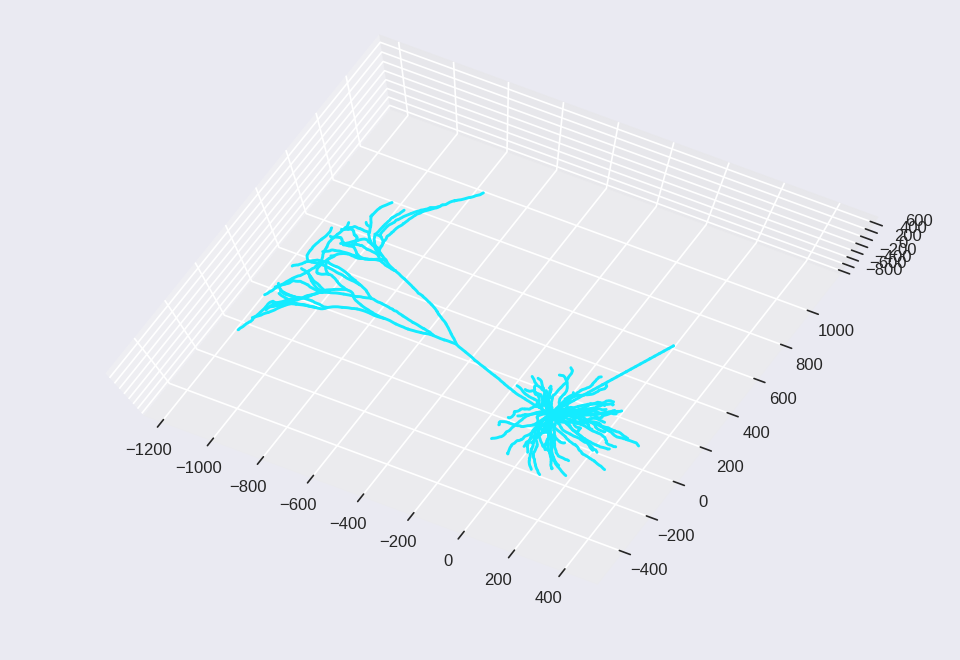

<neuron._PlotShapePlot.__call__.<locals>._get_pyplot_axis3d.<locals>.Axis3DWithNEURON at 0x7efdae597d00>

In [38]:
#print([i.loc for i in synapses]);
h.PlotShape(False).plot(plt)

<IPython.core.display.Javascript object>


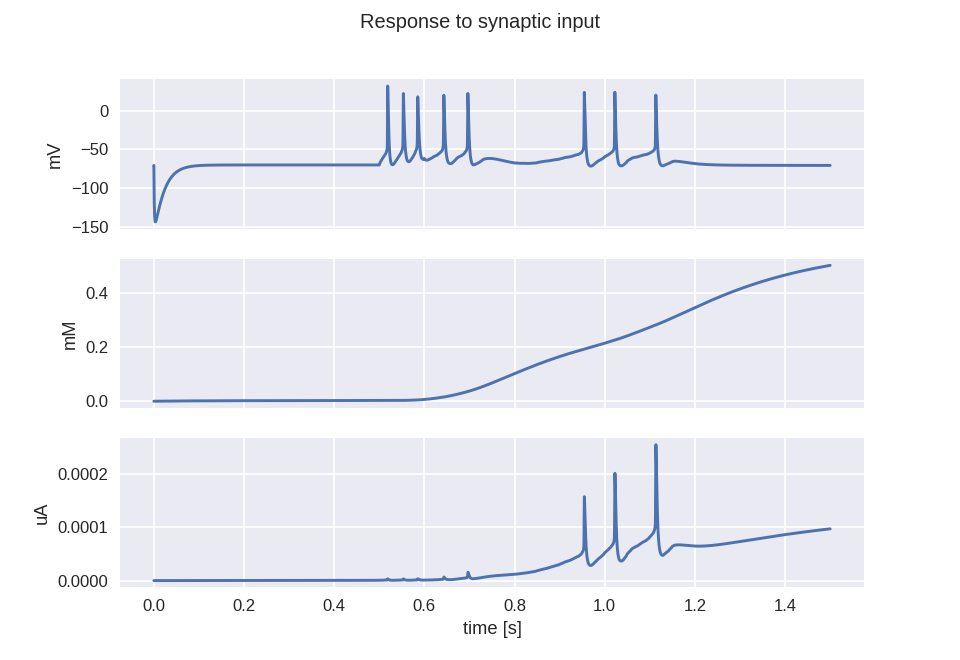

In [53]:
h.celsius = 23
create_ncs_distribution([i for i in range(12, 82, 20)])
#delete_all_ncs_mechanisms()
synapses = Synapse.create_synapses(num_rand_locs=100)
run_simulation(k_out=7.7e-5, total_protein=0.03821, runtime=1500, color='black')